## Purpose of this notebook 

1. Understanding GLM, Robust Linear Regression, comparing them using dummy data when there are outliers: the robust linear regression is when you are using studentT distribution.. in case when you see outliers in data, use student t distribution as it has wider tail than normal distribution and hence weighs the outliers when doing the fitting.
2. Hierarchical Linear Models in PyMC3,  it extends generalized linear models by relaxing the assumption that error components are independent. They are also called multilevel models. Wiki definition: these are models of parameters that vary at more tha one level.  ......

       2.1. Hierarchical linear models (or multilevel regression) organizes the data into a hierarchy of regressions, for  example where A is regressed on B, and B is regressed on C.
       
       2.2 Fitting statistical models to dependent data.observations are correlated due to some feature of the study design

       2.3 Multilevel models: example how much variance is there in long term trends of substance use for a sample of drug users. How much of unexplained variance among hospitals in mean patient satisfaction is due to sixe of poulation.
       
       2.4 Advantage: Estimate one parameter representing the variance of given random coefficients across clusters, rather than unique regression coefficients for every possible cluster.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns


In [2]:
from pymc3 import *
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import theano


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sidha\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# generating artifical data with 100 points
size = 100
intercept = 1
slope = 2
x = np.linspace(0, 1, size)
true_regression_line = intercept + slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

In [5]:
data.keys()

dict_keys(['x', 'y'])

Text(0.5, 1.0, 'Raw Data')

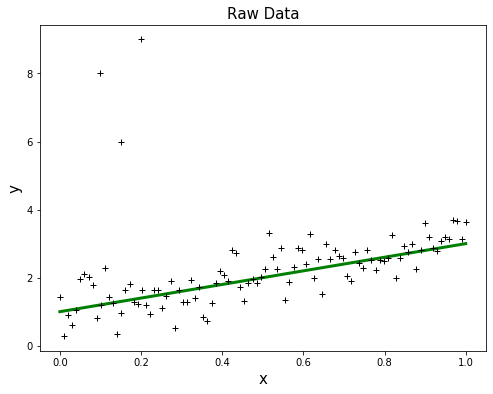

In [6]:
plt.figure(figsize = (8, 6))
plt.plot(x,true_regression_line, color='g', linewidth = 3.)
plt.plot(data['x'], data['y'], 'k+')
plt.xlabel('x', size = 15)
plt.ylabel('y', size = 15)
plt.title('Raw Data', size=15)

In [7]:
with Model() as model:
    glm.GLM.from_formula('y ~ x', data)
    trace = sample(2000, cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 70 seconds.
The acceptance probability does not match the target. It is 0.8940622356523886, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.532,0.233,1.091,1.950,0.006,0.004,1761.0,1761.0,1757.0,1859.0,1.0
x,1.466,0.408,0.734,2.263,0.010,0.007,1694.0,1641.0,1690.0,1730.0,1.0
sd,1.194,0.088,1.038,1.364,0.002,0.001,2232.0,2211.0,2263.0,2322.0,1.0


In [9]:
trace.varnames

['Intercept', 'x', 'sd_log__', 'sd']

C:\Users\sidha\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000203D869E6C8>],
      dtype=object)

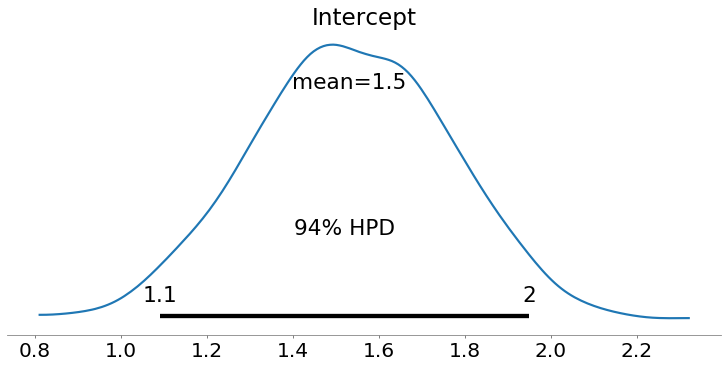

In [10]:
plots.plot_posterior(trace, varnames = ['Intercept'], figsize = (10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000203D808BE08>],
      dtype=object)

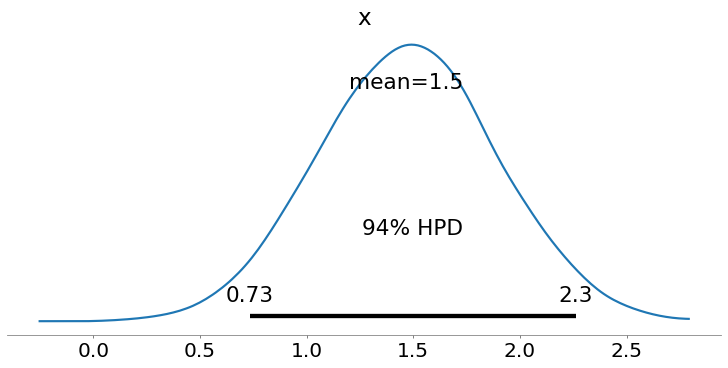

In [11]:
plots.plot_posterior(trace, varnames = ['x'], figsize = (10,5))

## Concept

To see the fit we plot the posterior predictive regression lines by taking regression parameters from posterior distribution. We can see the predicted regression lines are weighing the outliers more.We want to limit the effect of outliers here. The normal distribution does have lot of weights distributed on tail and hence outlier will effect the fit strongly. problem is the light tails of the Normal distribution we can instead assume that our data is not normally distributed but instead distributed according to the Student T distribution which has heavier tails.



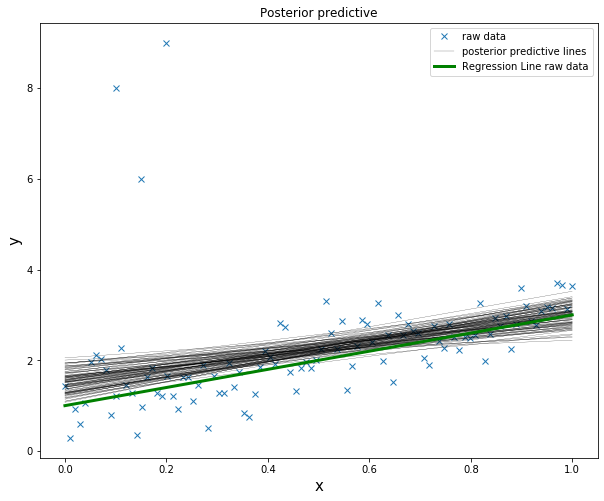

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(x_out, y_out, 'x', label='raw data')
plot_posterior_predictive_glm(trace, samples=100, label='posterior predictive lines')
plt.plot(x, true_regression_line, label='Regression Line raw data', lw=3., c='g')
plt.xlabel('x', size = 15)
plt.ylabel('y', size = 15)
plt.legend()


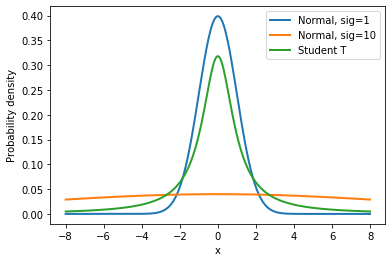

In [44]:
normal_dist = Normal.dist(mu=0, sigma=1)
t_dist = StudentT.dist(mu=0, lam=1, nu=1)
normal_dist_2 = Normal.dist(mu=0, sigma=10)

x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal, sig=1', lw=2.)
plt.plot(x_eval, theano.tensor.exp(normal_dist_2.logp(x_eval)).eval(), label='Normal, sig=10', lw=2.)

plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend();

## We can see that the probability of values away from mean(0) is more in studentT distribution than the normal distribution hence we will use studentT distribution,The outliers are barely influencing our estimation at all because our likelihood function assumes that outliers are much more probable than under the Normal distribution. 

In [14]:
help(glm.GLM.from_formula)

Help on method from_formula in module pymc3.glm.linear:

from_formula(formula, data, priors=None, vars=None, family='normal', name='', model=None, offset=0.0, eval_env=0) method of pymc3.model.ContextMeta instance
    Creates GLM from formula.
    
    Parameters
    ----------
    formula: str - a `patsy` formula
    data: a dict-like object that can be used to look up variables referenced
        in `formula`
    eval_env: either a `patsy.EvalEnvironment` or else a depth represented as
        an integer which will be passed to `patsy.EvalEnvironment.capture()`.
        See `patsy.dmatrix` and `patsy.EvalEnvironment` for details.
    Other arguments are documented in the constructor.



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 87 seconds.


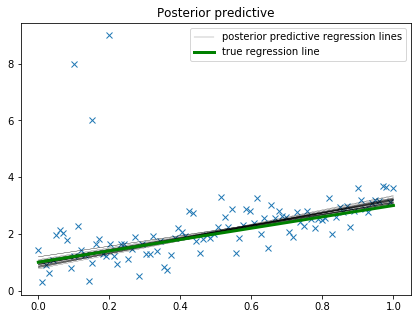

In [15]:
with Model() as model:
    family = glm.families.StudentT()
    glm.GLM.from_formula('y ~ x', data, family=family) # family defines which distribution to use
    # by default its normal distribution
    trace_robust = sample(2000, cores=2)

plt.figure(figsize=(7, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace_robust,label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='g')
plt.legend();

In [16]:
ls

 Volume in drive C is Windows
 Volume Serial Number is C2AA-54D0

 Directory of C:\Users\sidha\Desktop\bayesian_project

04/30/2020  10:18 AM    <DIR>          .
04/30/2020  10:18 AM    <DIR>          ..
04/29/2020  04:09 PM    <DIR>          .ipynb_checkpoints
04/17/2020  04:27 PM           146,523 algo_MH_MCMC.jpeg
04/21/2020  04:30 PM    <DIR>          basics
04/29/2020  05:01 PM    <DIR>          bayesian_linear_regression_project
04/29/2020  10:34 PM    <DIR>          bayesian_multinomial_dirichlect project
04/29/2020  05:01 PM             2,331 data1999.txt
04/16/2020  05:13 PM               539 EISN_current.csv
04/17/2020  04:27 PM           138,918 likelihood_log_how_why.jpeg
04/30/2020  10:18 AM            90,688 lin_regression.ipynb
04/15/2020  09:18 PM           266,881 LinearRegression_example.ipynb
04/28/2020  11:38 AM    <DIR>          MCMC_sleep_awake project
04/23/2020  03:01 PM         1,177,896 MCMC_sunspot_count.ipynb
04/22/2020  03:38 PM            47,890 photon flu

In [3]:
sat_data = pd.read_csv(get_data(r'C:\Users\sidha\Desktop\bayesian_project\data1999.txt'))

In [4]:
sat_data.head()

,spend,stu_tea_rat,salary,prcnt_take,sat_v,sat_m,sat_t
Alabama,4.405,17.2,31.144,8,491,538,1029
Alaska,8.963,17.6,47.951,47,445,489,934
Arizona,4.778,19.3,32.175,27,448,496,944
Arkansas,4.459,17.1,28.934,6,482,523,1005
California,4.992,24.0,41.078,45,417,485,902


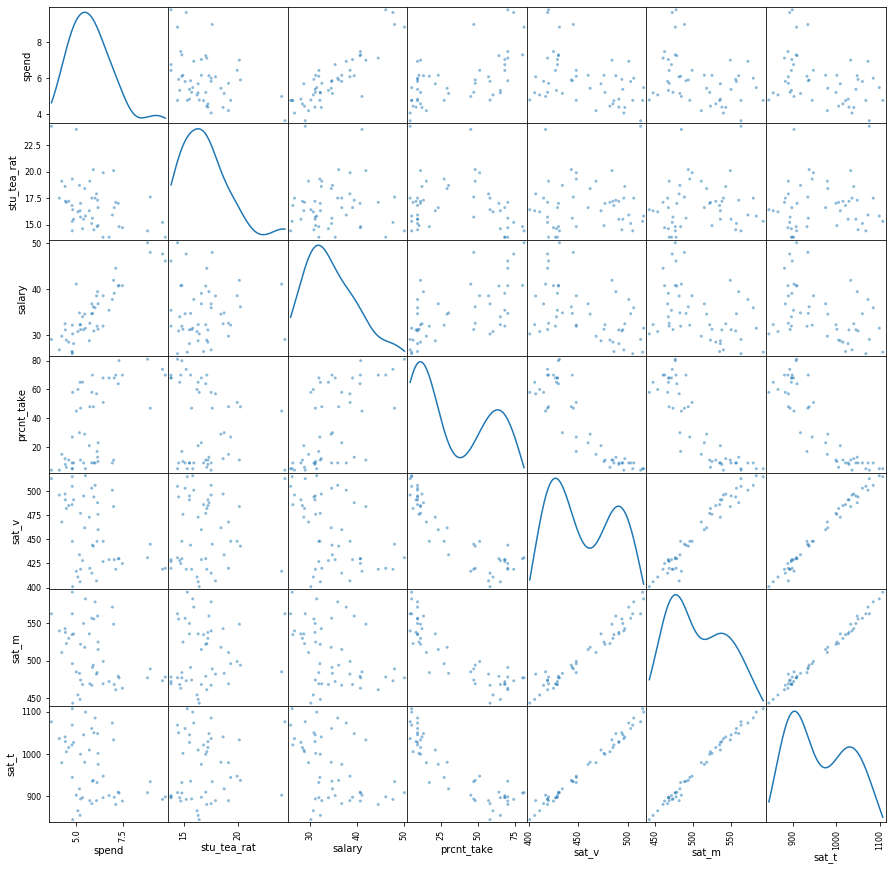

In [5]:
scatter_matrix(sat_data, figsize  = [15, 15], diagonal = "kde")
plt.show()

# concept

we are workign on explanation of hierarchical/multi-level Bayesian modeling. Hierachical modelling is especially advantageous when multi-level data is used, making the most of all information available by its 'shrinkage-effect'.

In [16]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu = 0, sigma=10)
    grp_sd = Uniform('grp_sd', 0, 200)
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std()),
              'spend': Normal.dist(mu=grp_mean, sigma=grp_sd),
              'stu_tea_rat': Normal.dist(mu=grp_mean, sigma=grp_sd),
              'salary': Normal.dist(mu=grp_mean, sigma=grp_sd),
              'prcnt_take': Normal.dist(mu=grp_mean, sigma=grp_sd)
              }
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data, priors=priors)
    trace_sat = sample(1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, prcnt_take, salary, stu_tea_rat, spend, Intercept, grp_sd, grp_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 590 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7170371332785532, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
trace_sat.varnames
var_names = ['grp_mean',
 'spend',
 'stu_tea_rat',
 'salary',
 'prcnt_take',
 'grp_sd',
 'sd']

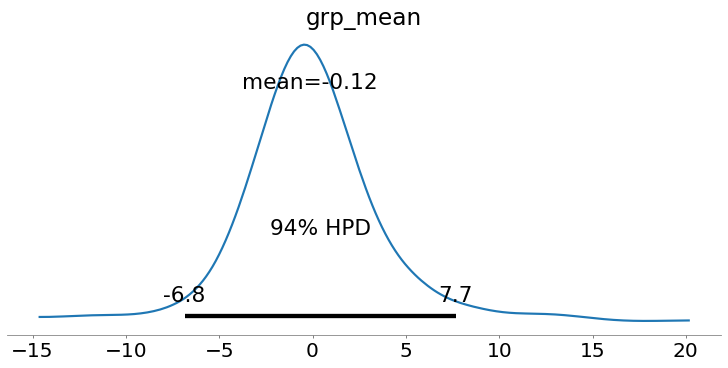

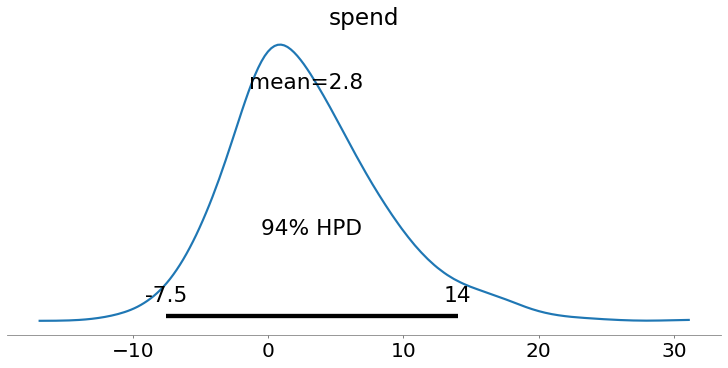

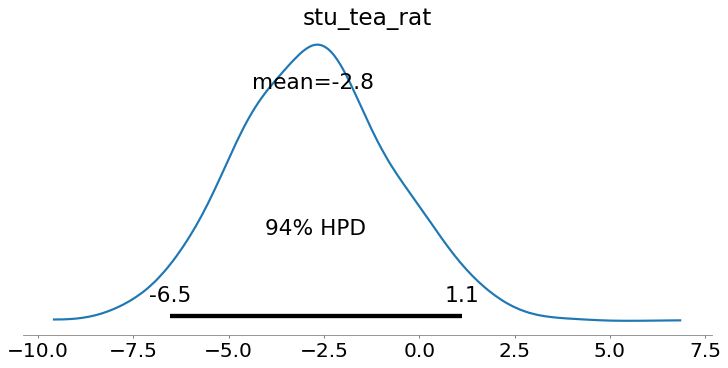

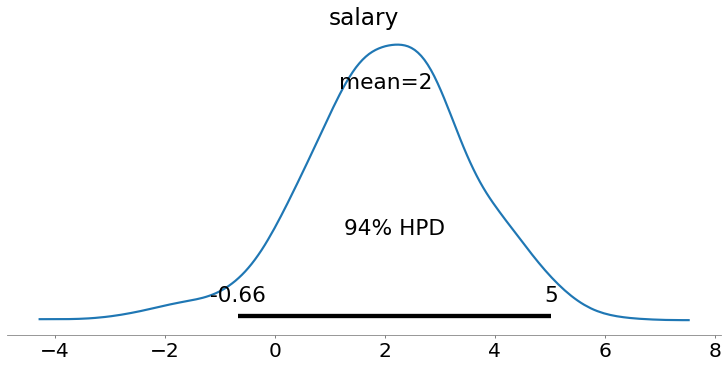

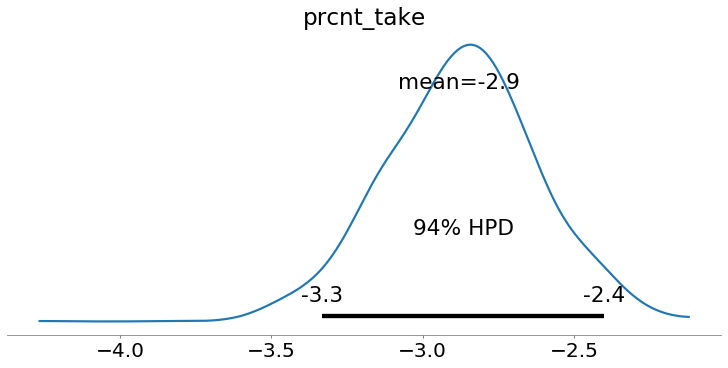

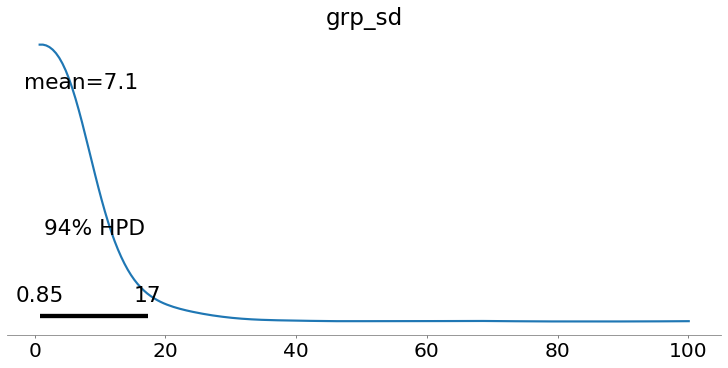

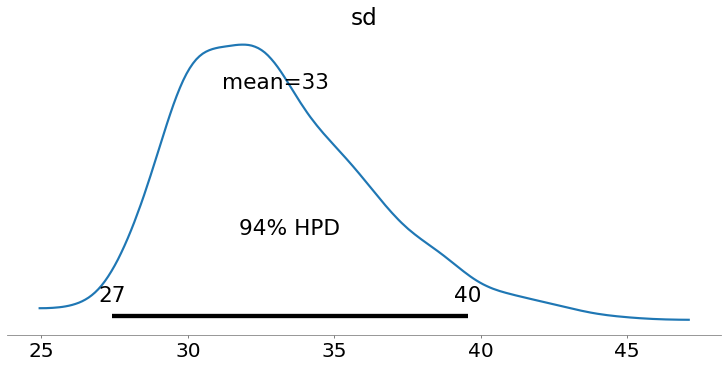

In [26]:
for var_name in var_names:
    plots.plot_posterior(trace_sat, varnames = [var_name], figsize = (10,5))

### Please note that HPD is similar to confidence interval

### Im not sure why these chains are failing, tried multiple values in model but still tehy are failing

In [27]:
help(trace_to_dataframe)

Help on function trace_to_dataframe in module pymc3.backends.tracetab:

trace_to_dataframe(trace, chains=None, varnames=None, include_transformed=False)
    Convert trace to Pandas DataFrame.
    
    Parameters
    ----------
    trace: NDarray trace
    chains: int or list of ints
        Chains to include. If None, all chains are used. A single
        chain value can also be given.
    varnames: list of variable names
        Variables to be included in the DataFrame, if None all variable are
        included.
    include_transformed: boolean
        If true transformed variables will be included in the resulting
        DataFrame.



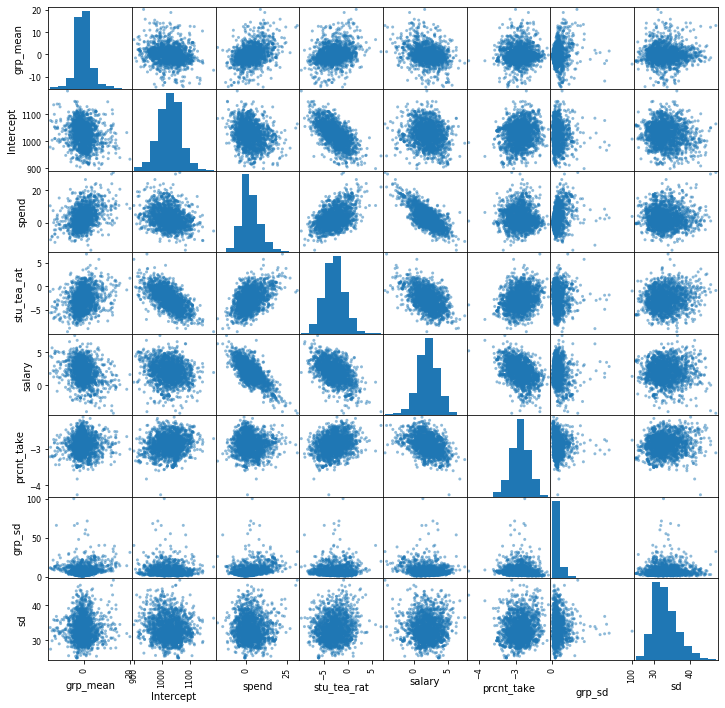

In [28]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));
